# Learning Distance


## Neural Network or Multilayer Perceptron
A Multilayer Perceptron consists of an input layer, multiple hiddenlayers and an output layer. The MLP is a feedforward algorithm, because inputs are combined with the initial weights in a weighted sum and subjected to the activation function, just like in the simple Perceptron. But the difference is that each linear combination is propagated to the next layer. Each layer is feeding the next one with the result of their computation. This goes through all the hidden layers to the output layer.

The advantage of a multilayer perceptron compared to a classical perceptron (single layer) is that it is capable of learning a function between input and output that is non linear. Therfore it can learn signifacently more complex functions capturing the relation from input to output data.

This tutorial will give a brief overview into training and testing an MLP and heighlight typical pitfalls that might occure easily.


# Coding: Getting Started
Before you get started you need to follow the descriptions of the Git-Repository and make sure that all required packages are properly installed. It is recommended to work in a virtual environment. Start your virtual environment **before** you launch this jupyter-notebook. Then you may need to change the kernel: *Kernel &rarr; Change kernel &rarr; venv*

In [185]:
import torch
import cv2
import os 
import glob
import argparse
import data_setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlp_utils as mlp_utils
import train_utils
from tqdm.auto import tqdm
from model import DistNet_MLP as mlp

In [186]:
YOLO_MODEL = './model/yolo_model.pt'
FILE = '../../data/test/img/2023-6-28_17-06-35-343099.png'

PATH_TRAIN = '../../data/train/img'
PATH_VAL = '../../data/val/img'
PATH_TEST = '../../data/test/img'
PATH_CSV_TRAIN = '../../data/train/train.csv'
PATH_CSV_VAL = '../../data/val/val.csv'
PATH_CSV_TEST = '../../data/test/test.csv'

PATH_MODEL_SAVE = './model/mlp_model_trained.pth'
ROBOTS = ["ollie", "grace", "alan", "hermann", "kaethe"]
CAM_ROBOT = "ollie"
MAX_DIST = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FILE_EXTENSION = "*.png"
CONFIDENCE = 0.7
NUM_EPOCHS = 100
RELOAD_WEIGHTS = True
LR = 0.0001

In [187]:
# Loading YOLOv5 Model
model_YOLO = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL, verbose=False)
model_YOLO.conf = CONFIDENCE
model_YOLO.to(DEVICE)

YOLOv5 🚀 2023-8-13 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Part 1.1: Training a small MLP (multi-layer perceptron)

The provided code automatically detects little Lego Robots in an image. For detection we use a fine-tuned YOLOv5 network that estimates bounding boxes, that each capture the rough dimensions of the projected object.
Given the height of an object bounding box, the camera's focal length as well as the actual robot's height we compute the absolut distance between "CAM_ROBOT" and all visible robots in the image.

In [188]:
# Load the training and validation image sets.
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
train_images = glob.glob(file_pattern)

file_pattern = os.path.join(PATH_VAL, FILE_EXTENSION)
valid_images = glob.glob(file_pattern)

# Pass images through yolo and get bounding boxes with their corresponding csv distance labels
train_data = mlp_utils.images2data(model_YOLO, train_images, PATH_CSV_TRAIN, verbose = False)
valid_data = mlp_utils.images2data(model_YOLO, valid_images, PATH_CSV_VAL, verbose = False)

In [189]:
# Load the MLP model
model_MLP = mlp.MLP()

# Define optimizer
optimizer = torch.optim.Adam(params=model_MLP.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

# Pass the data through the dataloader
train_dataloader, valid_dataloader = data_setup.create_dataloader(train_data, valid_data, batch_size=5)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


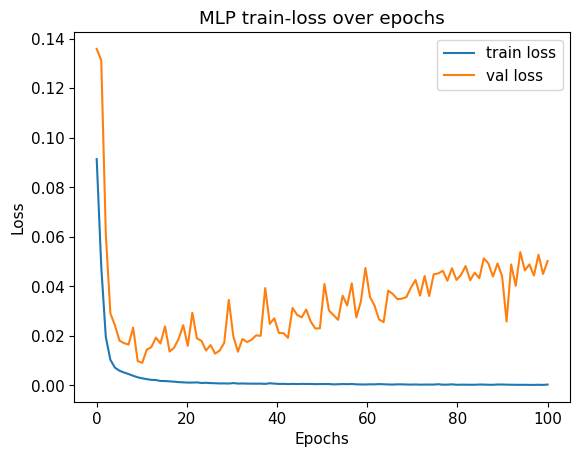

In [190]:
# Set training
best_metric = float('inf')  # Initialize with a large value for loss
train_loss_plotting = []
validation_loss_plotting = []

# Training Loop
for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_utils.train_step(model_MLP, train_dataloader, loss_fn, optimizer, DEVICE)
    validation_loss = train_utils.validation_step(model_MLP, valid_dataloader, loss_fn, DEVICE)

    # add train loss fro plotting
    train_loss_plotting.append(train_loss.item())
    validation_loss_plotting.append(validation_loss.item())
  
    if validation_loss < best_metric:
        best_metric = validation_loss
        torch.save(model_MLP.state_dict(), PATH_MODEL_SAVE)

#    if(epoch % 10 == 0):
#        print(f"Epoch: {epoch}\n------")
#        print(f"Train loss: {train_loss:.5f}\n")
        
# plotting stuff
%matplotlib inline
x_err = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS)
plt.plot(x_err, train_loss_plotting, label='train loss')
plt.plot(x_err, validation_loss_plotting, label='val loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP train-loss over epochs')

# Display the plot
plt.legend()

plt.show()

### Question: 
Can you overfit intentionally to the training data? How does the validation curve will look like? Please verify your assumption.

How does the number of layer effect the training result of the MLP?

*Answer:*

## Part 1.2: Inference on a single image

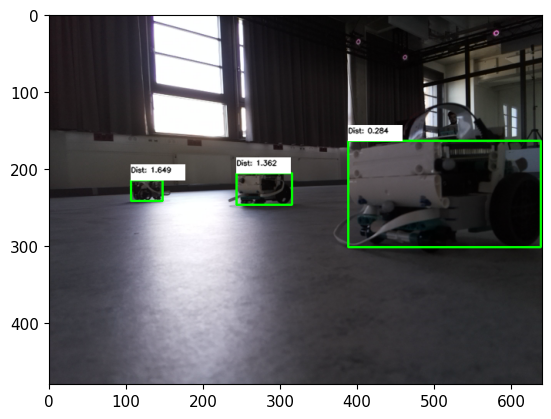

In [191]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval() 

# yolo bounding box detection
res = model_YOLO(FILE)

bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]
image = cv2.imread(FILE)

for box in bounding_boxes:
    
    BBH = (box[3] - box[1]) / 640
    BBW = (box[2] - box[0]) / (640)
    BBCenter = torch.tensor([(box[2] + box[0]) / 2 , (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
    BBAspectRatio = BBW / BBH / 6
    BBClass = box[5]
    BBConf = box[4]
    BBArea = BBH * BBW
    BBAreaCover = (BBArea)
    params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
    input = torch.cat((params, BBCenter), 0)
    distance = model(input)
    
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    image_with_rectangle = cv2.rectangle(image, (int(box[0]), int(box[1])-20), (int(box[0]) + 70, int(box[1])), (255,255,255), -1)
    img_drawn = cv2.putText(image, f"Dist: {(distance.item() * MAX_DIST):.3f}", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.LINE_AA)
    image_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)


# visualize frame with overlayed 
# bounding boxes and distance estimates
%matplotlib inline

fig = plt.figure()
plt.imshow(image_rgb)
plt.show()

## Part 1.3: Visualization

... now let's run this code on several consequtive frames and visualize the relationship between object height and its distance.

In [192]:
print("Loading Pictures...")

file_pattern = os.path.join(PATH_TEST, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

print("Reading pictures...")

values = {}

first_image = cv2.imread(picture_files[0])
height, width, _ = first_image.shape

for i, file in enumerate(picture_files):

    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    for box in bounding_boxes:
        BBH = (box[3] - box[1]) / 640
        BBW = (box[2] - box[0]) / 640

        BBCenter = torch.tensor([(box[2] + box[0]) / 2, (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
        BBAspectRatio = BBW / BBH / 6
        BBClass = box[5]
        BBConf = box[4]
        BBArea = BBH * BBW
        BBAreaCover = (BBArea)
        params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
        input = torch.cat((params, BBCenter), 0)
        distance = model(input)
        
        values.setdefault(distance, []).append(box[3] - box[1])



Loading Pictures...
Reading pictures...


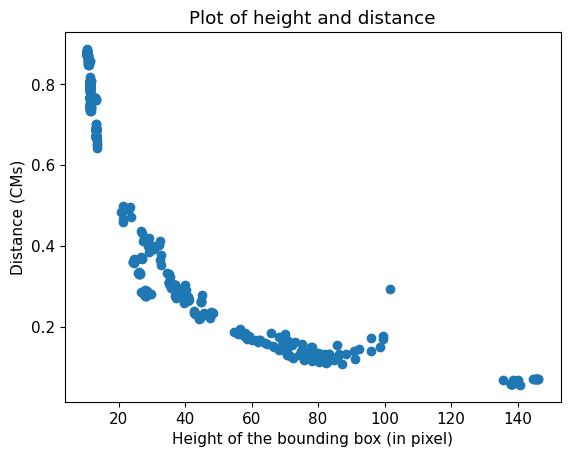

In [193]:
x = []
y = []

for dist in values:
    for height in values[dist]:
        x.append(height.item())
        y.append(dist.detach().numpy())

plt.scatter(x, y)

plt.xlabel('Height of the bounding box (in pixel)')
plt.ylabel('Distance (CMs)')
plt.title('Plot of height and distance')

plt.show()

## Part 2.1: Evaluation

Groudtruth robot poses were captured with a motion capture system for all robots visible in this data. Poses were saved in the provided .csv file. In this part of the tutorial let's anayse the observed error. How does this relate to the object's distance? What are possible causes of this error?

In [194]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_PRETRAINED, map_location=torch.device(DEVICE)))
model.eval()

# get list of picture files in PATH
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

# read csv file with ground truth robot poses
df = pd.read_csv(PATH_CSV_TRAIN, header=None)

# get column for each robot in csv file
row = df.iloc[0].to_numpy()
robot_col = {}
for rbo in ROBOTS:
    bool_array = row == rbo
    robot_col[rbo] = bool_array.argmax()
cam_robot_col = robot_col[CAM_ROBOT]

err = []
distance_x = []

for i, file in enumerate(picture_files):

    # -----------------------------------------------------------------
    # LOAD GROUNDTRUTH DISTANCES FOR EACH PICTURE
    # -----------------------------------------------------------------
    
    row_val = os.path.basename(file)
    row_matching_value = df[df.iloc[:, 0] == row_val]
    print("********")
    print(row_val)

    if row_matching_value.empty:
        print("Skipping, since no matching image name in csv")
        continue

    row = row_matching_value.index[0]

    if type(df.at[row,2]) is not str and math.isnan(df.at[row,2]):
        print("Skipping, since no robots visable on image ")
        continue
       
    # robots present in current frame
    robot_list = df.at[row,2].split()
    
    distance_gt = []
    
    for robot in zip(robot_list):
        
        # pose of the camera robot
        camX = df.at[row,cam_robot_col+2]
        camY = df.at[row,cam_robot_col]

        # pose of neighboring robot
        robotX = df.at[row, robot_col[robot[0]] + 2]
        robotY = df.at[row, robot_col[robot[0]]]

        # GROUNDTRUTH DISTANCE
        distance = np.sqrt((float(robotX)-float(camX)) ** 2 + (float(robotY)-float(camY)) ** 2)
        distance = distance / 100
        
        print(f"distance_gt: {distance}")
        
        distance = torch.tensor(distance, dtype = torch.float32,)
        distance_gt.append(distance)
        
    # -----------------------------------------------------------------
    # COMPUTE DISTANCE FROM BOUNDING BOX HEIGHT
    # -----------------------------------------------------------------
    
    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    distance_estim = []
    
    for box in bounding_boxes:
    
        BBH = (box[3] - box[1]) / 640
        BBW = (box[2] - box[0]) / (640)
        BBCenter = torch.tensor([(box[2] + box[0]) / 2 , (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
        BBAspectRatio = BBW / BBH / 6
        BBClass = box[5]
        BBConf = box[4]
        BBArea = BBH * BBW
        BBAreaCover = (BBArea)
        params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
        input = torch.cat((params, BBCenter), 0)
        distance = model(input)
        distance = distance[0].detach()
        distance_estim.append(distance * MAX_DIST)
        
        print(f"distance_estim: {distance * MAX_DIST}")
        
    # -----------------------------------------------------------------
    # COMPUTE ERROR
    # -----------------------------------------------------------------
    
    if(bounding_boxes.shape[0] == len(robot_list)):

        error = abs(np.array(distance_gt) - np.array(distance_estim))
        err.extend(error)
        distance_x.extend(distance_gt)

********
2023-6-28_17-14-45-756992.png
distance_gt: 0.3155240818351403
distance_gt: 3.778328848866088
distance_gt: 4.927410998490273
distance_gt: 3.678965914334902
distance_estim: 0.5515711307525635
distance_estim: 4.40010404586792
distance_estim: 4.181507110595703
distance_estim: 3.23502516746521
********
2023-6-28_17-14-45-798767.png
distance_gt: 0.31194829970741805
distance_gt: 3.7783595390285143
distance_gt: 4.927295745423304
distance_gt: 3.6790048635242454
distance_estim: 0.5558813214302063
distance_estim: 4.399998188018799
distance_estim: 4.177371978759766
distance_estim: 3.256290912628174
********
2023-6-28_17-14-45-840106.png
distance_gt: 0.30869088965782093
distance_gt: 3.778347856993213
distance_gt: 4.927295763400836
distance_gt: 3.6789836432355405
distance_estim: 0.556769609451294
distance_estim: 4.399961948394775
distance_estim: 4.172772407531738
distance_estim: 3.2499008178710938
********
2023-6-28_17-14-45-885886.png
distance_gt: 0.3055268779027879
distance_gt: 3.77834883

distance_estim: 0.563715398311615
distance_estim: 4.399609088897705
distance_estim: 4.186115741729736
distance_estim: 3.252423048019409
********
2023-6-28_17-14-47-168362.png
distance_gt: 0.32324607871646654
distance_gt: 3.778339445175189
distance_gt: 4.927392924619998
distance_gt: 3.678974170378526
distance_estim: 0.5647245645523071
distance_estim: 4.399703025817871
distance_estim: 4.157925128936768
distance_estim: 3.276139259338379
********
2023-6-28_17-14-47-211557.png
distance_gt: 0.32322930159145424
distance_gt: 3.7783174662471963
distance_gt: 4.927398296299151
distance_gt: 3.678968509677135
distance_estim: 0.5628242492675781
distance_estim: 4.399739742279053
distance_estim: 4.159029960632324
distance_estim: 3.2563233375549316
********
2023-6-28_17-14-47-256633.png
distance_gt: 0.32323189169245553
distance_gt: 3.778329409814662
distance_gt: 4.927403364080032
distance_gt: 3.678968396950067
distance_estim: 0.5651076436042786
distance_estim: 4.399392127990723
distance_estim: 4.172652

distance_estim: 2.1046037673950195
distance_estim: 4.395193576812744
distance_estim: 4.171144962310791
distance_estim: 3.2504992485046387
********
2023-6-28_17-14-58-699808.png
distance_gt: 2.258751636468169
distance_gt: 3.7783366514346204
distance_gt: 4.927286394674891
distance_gt: 3.6789599483939406
distance_estim: 2.1009349822998047
distance_estim: 4.392994403839111
distance_estim: 4.139308452606201
distance_estim: 3.2551238536834717
********
2023-6-28_17-14-58-742529.png
distance_gt: 2.2585376317997254
distance_gt: 3.7783548197490653
distance_gt: 4.927398491952696
distance_gt: 3.678964202703154
distance_estim: 2.094261884689331
distance_estim: 4.390920639038086
distance_estim: 4.140561103820801
distance_estim: 3.228463888168335
********
2023-6-28_17-14-58-825925.png
distance_gt: 2.261682626478862
distance_gt: 3.7783517018939103
distance_gt: 4.927253257304559
distance_gt: 3.678970124270775
distance_estim: 2.146456480026245
distance_estim: 4.3979172706604
distance_estim: 4.1369886398

distance_estim: 2.210998296737671
distance_estim: 4.398675918579102
distance_estim: 4.148405075073242
distance_estim: 3.2476048469543457
********
2023-6-28_17-15-00-506288.png
distance_gt: 2.3838832052649495
distance_gt: 3.7783706975798244
distance_gt: 4.927389178984584
distance_gt: 3.678963309142382
distance_estim: 2.21171236038208
distance_estim: 4.39875602722168
distance_estim: 4.181506633758545
distance_estim: 3.238691806793213
********
2023-6-28_17-15-00-588797.png
distance_gt: 2.383848647702705
distance_gt: 3.778349528308238
distance_gt: 4.927396851290284
distance_gt: 3.6789622461241542
distance_estim: 2.2534422874450684
distance_estim: 4.398852348327637
distance_estim: 4.147738933563232
distance_estim: 3.2492449283599854
********
2023-6-28_17-15-00-630440.png
distance_gt: 2.382986662159745
distance_gt: 3.7783543153323844
distance_gt: 4.927290445352865
distance_gt: 3.6789708320898784
distance_estim: 2.339965581893921
distance_estim: 4.398608684539795
distance_estim: 4.17836380004

distance_estim: 4.398966312408447
distance_estim: 1.9320605993270874
distance_estim: 4.152589321136475
distance_estim: 3.2254252433776855
********
2023-6-28_17-15-06-429339.png
distance_gt: 3.7783542654194724
distance_gt: 4.927369863881847
distance_gt: 2.0936004653700286
distance_gt: 3.678960989807741
distance_estim: 4.398340225219727
distance_estim: 4.063083648681641
distance_estim: 1.888580083847046
distance_estim: 3.2317163944244385
********
2023-6-28_17-15-06-470646.png
distance_gt: 3.77831475834459
distance_gt: 4.927385481452974
distance_gt: 2.094761934962127
distance_gt: 3.678962398778736
distance_estim: 4.398673057556152
distance_estim: 4.05333948135376
distance_estim: 1.8825441598892212
distance_estim: 3.2223856449127197
********
2023-6-28_17-15-06-512030.png
distance_gt: 3.7783282560920144
distance_gt: 4.927351754779194
distance_gt: 2.0968341791079608
distance_gt: 3.6789512913475813
distance_estim: 4.398626327514648
distance_estim: 4.030951499938965
distance_estim: 1.860486507

distance_estim: 0.7657683491706848
distance_estim: 1.7107148170471191
********
2023-6-28_17-15-29-873483.png
distance_gt: 0.6095201936627203
distance_gt: 1.8050675774515783
distance_estim: 0.7613005638122559
distance_estim: 1.703453540802002
********
2023-6-28_17-15-29-917989.png
distance_gt: 0.6060711378685345
distance_gt: 1.801893038845181
distance_estim: 0.7549526691436768
distance_estim: 1.697288990020752
********
2023-6-28_17-15-30-009681.png
distance_gt: 0.6057867653953537
distance_gt: 1.8016117957071691
distance_estim: 0.7504996061325073
distance_estim: 1.708274483680725
********
2023-6-28_17-15-30-054875.png
distance_gt: 0.6044867622732721
distance_gt: 1.800400048588169
distance_estim: 0.7376825213432312
distance_estim: 1.6566027402877808
********
2023-6-28_17-15-30-097406.png
distance_gt: 0.6003773228573945
distance_gt: 1.796488183316618
distance_estim: 0.7356827855110168
distance_estim: 1.5703675746917725
********
2023-6-28_17-15-30-140736.png
distance_gt: 0.5943027425847411


distance_estim: 1.0063257217407227
********
2023-6-28_17-15-34-717551.png
distance_gt: 0.798276629022042
distance_estim: 0.9817444682121277
********
2023-6-28_17-15-34-760619.png
distance_gt: 0.7852130180841624
distance_estim: 0.9704680442810059
********
2023-6-28_17-15-34-803394.png
distance_gt: 0.7713123867621424
distance_estim: 0.9645664095878601
********
2023-6-28_17-15-34-845986.png
distance_gt: 0.7578807243993309
distance_estim: 0.9514617919921875
********
2023-6-28_17-15-34-888824.png
distance_gt: 0.7436722456629627
distance_estim: 0.9457579851150513
********
2023-6-28_17-15-34-931719.png
distance_gt: 0.7303218969391899
distance_estim: 0.9380495548248291
********
2023-6-28_17-15-34-974702.png
distance_gt: 0.716877970225446
distance_estim: 0.9280576705932617
********
2023-6-28_17-15-35-060258.png
distance_gt: 0.6889715645247176
distance_estim: 0.891832172870636
********
2023-6-28_17-15-35-103224.png
distance_gt: 0.674616213798465
distance_estim: 0.8812035322189331
********
2023-6

NameError: name 'math' is not defined

## Part 2.2: Visualization
...now let's visualize again.

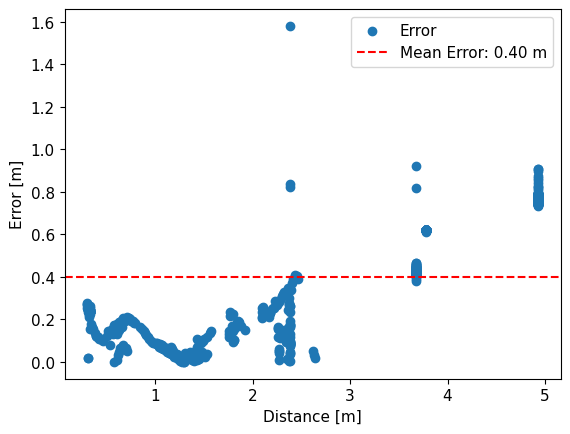

In [195]:
plt.scatter(distance_x, err, label='Error')
mean_err = np.mean(err)
plt.axhline(y=mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.2f} m')

# Adding labels and title
plt.xlabel('Distance [m]')
plt.ylabel('Error [m]')

# Display the plot
plt.legend()
plt.show(block=True)

## Question 1:
Please describe the behavior of the error. What are possible causes for errors that you observe? (Please name at least three causes)

*Answer:*